<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#Python-details" data-toc-modified-id="Python-details-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Python details</a></span><ul class="toc-item"><li><span><a href="#using-pcolormesh-to-plot-an-x-z-cross-section-of-the-cloudsat-radar-reflectivity" data-toc-modified-id="using-pcolormesh-to-plot-an-x-z-cross-section-of-the-cloudsat-radar-reflectivity-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>using pcolormesh to plot an x-z cross section of the cloudsat radar reflectivity</a></span></li><li><span><a href="#Prelimary-reading" data-toc-modified-id="Prelimary-reading-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Prelimary reading</a></span></li><li><span><a href="#New-library-functions" data-toc-modified-id="New-library-functions-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>New library functions</a></span></li></ul></li><li><span><a href="#Data-layout" data-toc-modified-id="Data-layout-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data layout</a></span></li></ul></li><li><span><a href="#Read-in-the-height-and-reflectivity-fields" data-toc-modified-id="Read-in-the-height-and-reflectivity-fields-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read in the height and reflectivity fields</a></span></li><li><span><a href="#Make-a-masked-array-of-the-reflectivity-so-that-pcolormesh-will-plot-it" data-toc-modified-id="Make-a-masked-array-of-the-reflectivity-so-that-pcolormesh-will-plot-it-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Make a masked array of the reflectivity so that pcolormesh will plot it</a></span></li><li><span><a href="#Subset-the-segment-to-the--3-minutes-containing-the-storm" data-toc-modified-id="Subset-the-segment-to-the--3-minutes-containing-the-storm-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Subset the segment to the  3 minutes containing the storm</a></span></li><li><span><a href="#convert-time-to-distance-by-using-pyproj-to-get-the-greatcircle-distance-between-shots" data-toc-modified-id="convert-time-to-distance-by-using-pyproj-to-get-the-greatcircle-distance-between-shots-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>convert time to distance by using pyproj to get the greatcircle distance between shots</a></span><ul class="toc-item"><li><span><a href="#The-radar-heights-aren't-quite-uniform" data-toc-modified-id="The-radar-heights-aren't-quite-uniform-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>The radar heights aren't quite uniform</a></span></li></ul></li><li><span><a href="#Make-the-plot-assuming-that-height-is-the-same-for-every-shot" data-toc-modified-id="Make-the-plot-assuming-that-height-is-the-same-for-every-shot-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Make the plot assuming that height is the same for every shot</a></span></li></ul></div>

# Introduction

## Python details

### using pcolormesh to plot an x-z cross section of the cloudsat radar reflectivity

This notebook shows how to read in the reflectivity, convert it to dbZe (dbZ equivalent,
which means the dbZ that the measured reflectivity would have it the cloud was made
of liquid water drops)

### Prelimary reading

* [pcolormesh](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.pcolormesh.html) is needed to
  plot a non-regular distance, height grid (non-regular because the radar returns are mapped onto a grid
  that is variable in height.

* [masked arrays](https://docs.scipy.org/doc/numpy-1.15.1/reference/maskedarray.generic.html#rationale) are needed
  because pcolormesh can't interpolate values that are set to np.nan like imshow does, it needs an indicator
  array to show which data is missing.
  
* [python datetime objects](https://www.w3schools.com/python/python_datetime.asp) -- needed to locate
  the time of each radar pulse during an orbit, and handle time spacing.

### New library functions

* [cloudsat.get_geo](https://github.com/phaustin/a301_code/blob/14d5f321f02b3d3974fab6cd2cfcff49c2643556/a301/cloudsat.py#L177) -- function that returns longtitudes, latitudes, times and surface elevations for each radar pulse.  (Don't need
  to understand the details of how this works, just how to call it)


## Data layout

The GEOPROF-GRANULE file contains two datasets with shape (37082, 125).  The first is Height, which is
the height in meters above a reference surface, ranging from -5000 meters to +25,000 meters. The second is Radar_Reflectivity, which is the Z
value at that height.  The two dimensions are:

* nray = 37082, which is the number of times the radar pulsed during an orbit

* nbin = 125, which is the number of height bins the reflectivity is placed into.  The heights of each
  sampled return will vary slightly from pulse to pulse.

#  Read in the height and reflectivity fields

The cell below opens ghe GEOPROF_GRANULE file and gets all the
data we'll need to plot.

In [1]:
from importlib import reload
import numpy as np
import datetime as dt
from datetime import timezone as tz
from matplotlib import pyplot as plt
import pyproj
from numpy import ma
import a301
from a301.cloudsat import get_geo
from pathlib import Path
from pyhdf.SD import SD, SDC

z_file= list(a301.test_dir.glob('*GEOPROF_GRANULE*hdf'))[0]
meters2km=1.e3

lats,lons,date_times,prof_times,dem_elevation=get_geo(z_file)
the_file = SD(str(z_file), SDC.READ)
radar_var = the_file.select('Radar_Reflectivity')
attrs = radar_var.attributes()
radar_reflectivity_raw = radar_var.get()
scale = attrs['factor']
missing_val = attrs['missing']
height = the_file.select('Height').get()
print(the_file.datasets())
the_file.end()

{'Height': (('nray:2B-GEOPROF', 'nbin:2B-GEOPROF'), (37082, 125), 22, 0), 'CPR_Cloud_mask': (('nray:2B-GEOPROF', 'nbin:2B-GEOPROF'), (37082, 125), 20, 1), 'Gaseous_Attenuation': (('nray:2B-GEOPROF', 'nbin:2B-GEOPROF'), (37082, 125), 22, 2), 'Radar_Reflectivity': (('nray:2B-GEOPROF', 'nbin:2B-GEOPROF'), (37082, 125), 22, 3)}


# Make a masked array of the reflectivity so that pcolormesh will plot it

We need to mask missing data identified by missing_val and scale the reflectivities by the scale factor (100).

In [2]:
hit=np.equal(radar_reflectivity_raw, missing_val)
#
# convert from int16 to float32
#
zvals=radar_reflectivity_raw.astype('float32')
zvals[hit]=np.nan
zvals = zvals/scale
zvals=ma.masked_invalid(zvals)

# Subset the segment to the  3 minutes containing the storm

You need to enter the start_hour and start_minute for the start time of your cyclone in the granule that
you found using quicklook. The times are in UCT (Greenwich mean).

In [3]:
first_time=date_times[0]
print(f'orbit start: {first_time}')
start_hour=6
start_minute=45
storm_start=dt.datetime(first_time.year,first_time.month,first_time.day,
                                        start_hour,start_minute,0,tzinfo=tz.utc)
#
# get 3 minutes of data from the storm_start
#
minutes=3
storm_stop=storm_start + dt.timedelta(minutes=minutes)
print(f'storm start: {storm_start}')
#
# get the part of the data that falls between the start and stop times.
#
hit_segment = np.logical_and(date_times > storm_start,date_times < storm_stop)
lats_segment = lats[hit_segment]
lons_segment=lons[hit_segment]
prof_times=prof_times[hit_segment]
zvals_segment=zvals[hit_segment,:]
height_segment=height[hit_segment,:]
date_times=date_times[hit_segment]

orbit start: 2008-03-22 06:00:33.115000+00:00
storm start: 2008-03-22 06:45:00+00:00


# convert time to distance by using pyproj to get the greatcircle distance between shots

The pyproj module has a convenience function that allows us to find the distance on the surface
of the earth between pulse positions given in lat/lon.  The loop below finds the great circle
distance between pulses, and saves it as a distance array in km.

In [4]:
great_circle=pyproj.Geod(ellps='WGS84')
distance=[0]
start=(lons_segment[0],lats_segment[0])
for index,the_lon in enumerate(lons_segment[1:]):
    azi12,azi21,step= great_circle.inv(lons_segment[index],lats_segment[index],
                                       the_lon,lats_segment[index+1])
    distance.append(distance[index] + step)
distance=np.array(distance)/meters2km

In [7]:
startlon,startlat = lons_segment[0], lats_segment[0]
stoplon,stoplat = lons_segment[-1], lats_segment[-1]
az1, az2, circle = great_circle.inv(startlon,startlat,stoplon,stoplat)
print(f'great circle distance is {circle/meters2km}')

great circle distance is [1227.92215237]


## The radar heights aren't quite uniform

Spacing between radar height levels differs slightly 

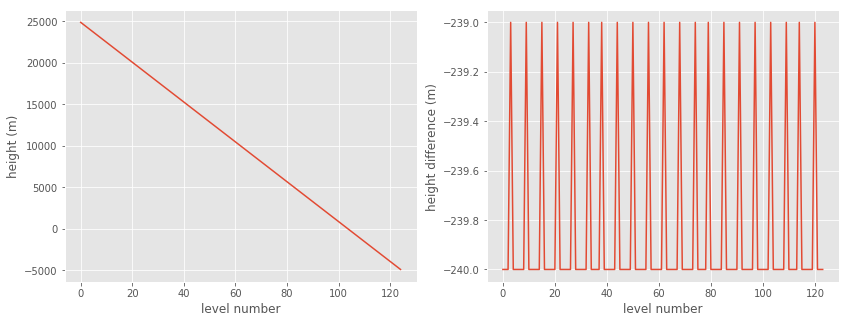

In [5]:
heights=height_segment[0,:]
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
plt.subplots_adjust(right=1.2)
ax1.plot(heights)
ax2.plot(np.diff(heights))
ax1.set(xlabel='level number',ylabel='height (m)')
ax2.set(xlabel='level number', ylabel='height difference (m)');

# Make the plot assuming that height is the same for every shot

i.e. assume that height[0,:] = height[1,:] = ...

in reality, the bin heights are depend on the details of the radar returns, so
we would need to historgram the heights into a uniform set of bins -- ignore that for this qualitative picture

We need to convert the row and column numbers to heights (yaxis) vs. distance (xaxis).  This is
done by pcolormesh, which builds a mesh of the image and then samples it in uniform
(distance, height) bins, sort of like pyresample.



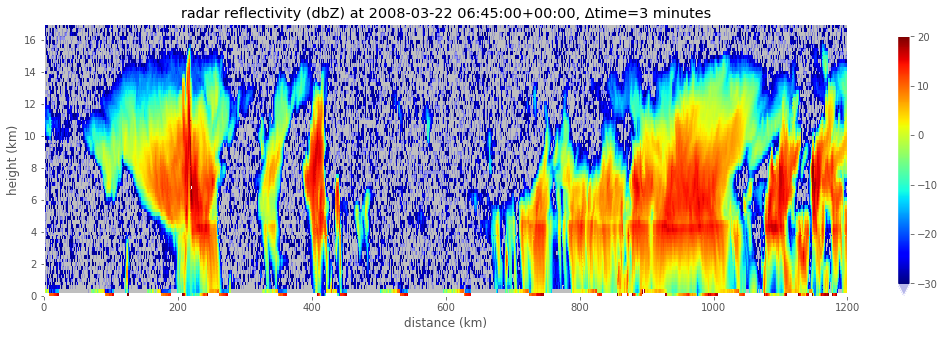

In [6]:
%matplotlib inline
plt.close('all')
fig,ax=plt.subplots(1,1,figsize=(18,5))

from matplotlib import cm
from matplotlib.colors import Normalize
vmin=-30
vmax=20
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=False)
cmap=cm.jet
cmap.set_over('w')
cmap.set_under('b',alpha=0.2)
cmap.set_bad('0.75') #75% grey

col=ax.pcolormesh(distance,height_segment[0,:]/meters2km,zvals_segment.T,cmap=cmap,
                  norm=the_norm)
ax.set(ylim=[0,17],xlim=(0,1200))
fig.colorbar(col,extend='both')
ax.set(xlabel='distance (km)',ylabel='height (km)',
       title=f'radar reflectivity (dbZ) at {storm_start}, Δtime={minutes} minutes');